Этот набор данных содержит подробную информацию о продажах автомобилей различных производителей и моделей. Набор данных включает в себя информацию о производителях, моделях автомобилей, технических характеристиках двигателя, типе топлива, годе выпуска, пробеге и конечной цене продажи.

In [6]:
!pip install catboost

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

In [22]:
# Загрузка и обработка данных
df = pd.read_csv("car_sales_data.csv")

# Базовая информация о данных
print("Размер датасета:", df.shape)
print("Информация о датасете:")
print(df.info())
print("\nСтатистическое описание:")
print(df.describe())
# Проверка пропущенных значений
print("\nПропущенные значения:")
print(df.isnull().sum())


Размер датасета: (50000, 7)
Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB
None

Статистическое описание:
        Engine size  Year of manufacture        Mileage          Price
count  50000.000000         50000.000000   50000.000000   50000.000000
mean       1.773058          2004.209440  112497.320700   13828.903160
std        0.734108             9.645965   71632.515602   16416.681336
min        1.0

In [23]:
TARGET_COL='Price'
NUMERICAL_COLS = ['Engine size', 'Year of manufacture', 'Mileage']
CATEGORICAL_COLS = ['Manufacturer', 'Model', 'Fuel type']
CURRENT_YEAR = 2025
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_SAVE_PATH = "best_model.pkl"

print("Числовые столбцы", NUMERICAL_COLS)
print("Объектные столбцы",CATEGORICAL_COLS)

Числовые столбцы ['Engine size', 'Year of manufacture', 'Mileage']
Объектные столбцы ['Manufacturer', 'Model', 'Fuel type']


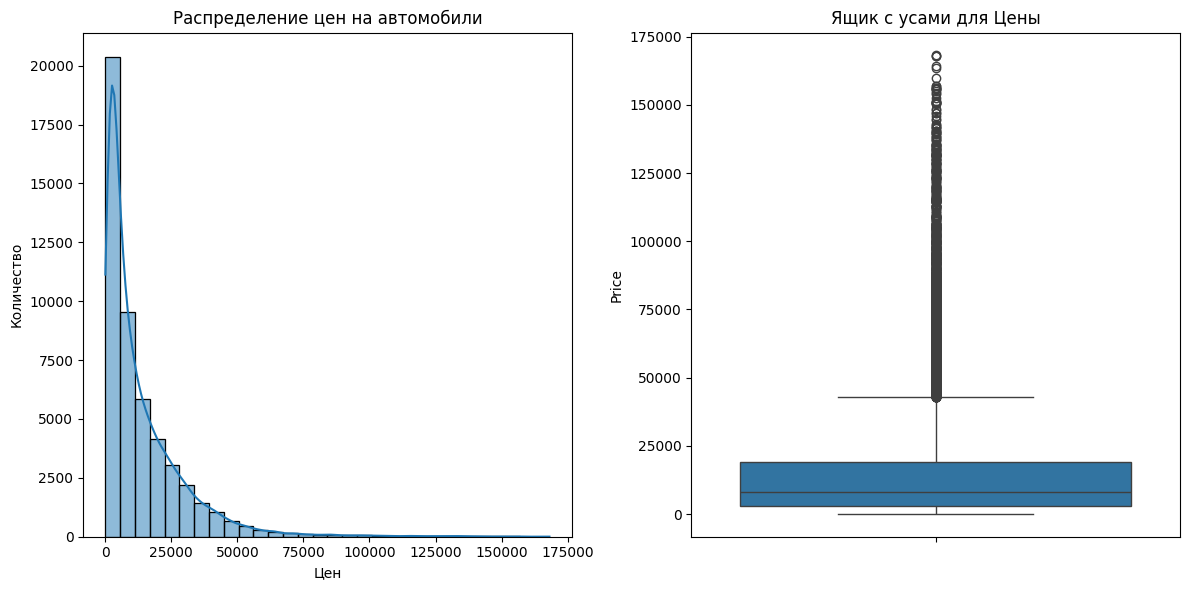

In [24]:
# Визуализация распределения целевой переменной
# Распределение цен
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Распределение цен на автомобили')
plt.xlabel('Цен')
plt.ylabel('Количество')

# Проверка на выбросы в Цене
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price'])
plt.title('Ящик с усами для Цены')
plt.tight_layout()
plt.show()


Предобработка данных...

Удаление выбросов...
Границы выбросов для Price: [-20887.88, 42975.12]
Обнаружено выбросов: 2649
Удалено 2649 выбросов (5.3%)

Создание новых признаков...

Матрица корреляций...


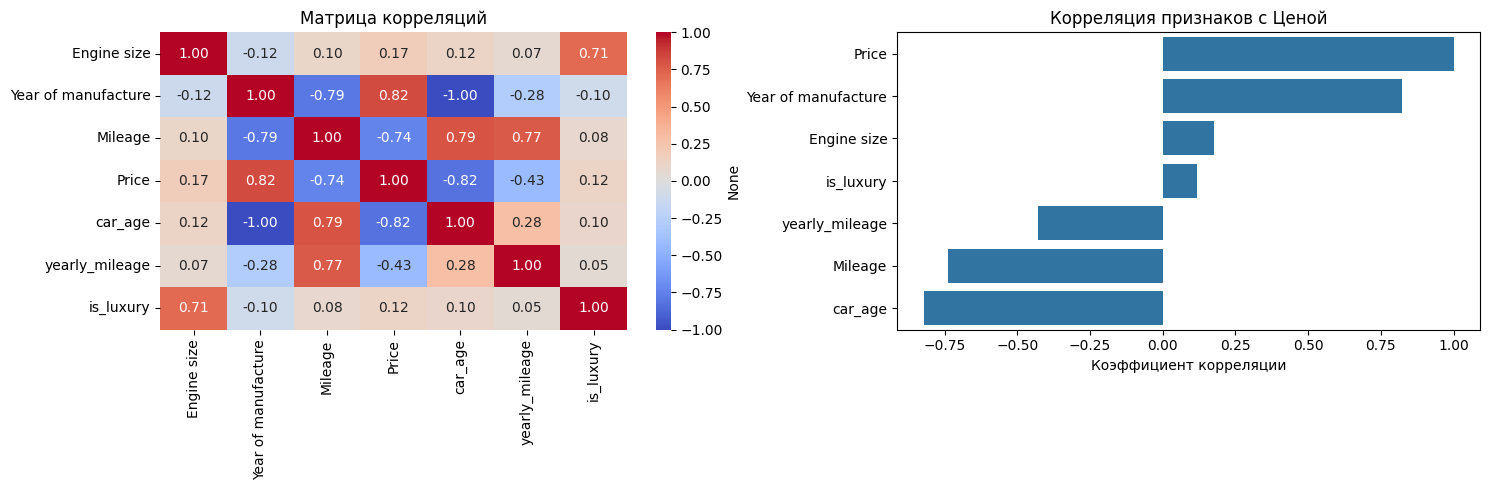


Логарифмирование целевой переменной...
Используемые числовые признаки: ['Engine size', 'Year of manufacture', 'Mileage', 'car_age', 'yearly_mileage', 'is_luxury']

Разделение данных на train/test...
Размер train: 37880, test: 9471


In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

def remove_outliers(df, column):
    """Удаление выбросов по межквартильному размаху"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Границы выбросов для {column}: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(
        f"Обнаружено выбросов: {((df[column] < lower_bound) | (df[column] > upper_bound)).sum()}"
    )
    return df.loc[~((df[column] < lower_bound) | (df[column] > upper_bound))]




def create_features(df):
  """Создание новых признаков с использованием правильного синтаксиса loc"""
  df = df.copy()

  df['car_age'] = CURRENT_YEAR - df['Year of manufacture']

  df['yearly_mileage'] = df['Mileage'] / (df['car_age'] + 1)  # +1 to avoid division by zero

  df['is_luxury'] = df['Manufacturer'].isin(['Porsche', 'BMW']).astype(int)

  return df

def preprocess_data(df):
  """Предобработка данных с улучшенной обработкой ошибок"""
  try:
      # Удаление выбросов
      print("\nУдаление выбросов...")
      original_size = df.shape[0]
      df = remove_outliers(df, TARGET_COL)
      new_size = df.shape[0]
      print(
          f"Удалено {original_size - new_size} выбросов ({((original_size - new_size) / original_size * 100):.1f}%)"
      )
      # Создание новых признаков
      print("\nСоздание новых признаков...")
      df = create_features(df)

      # Матрица корреляций
      print("\nМатрица корреляций...")
      correlation_matrix_visualizer(df)

      # Логарифмирование целевой переменной
      print("\nЛогарифмирование целевой переменной...")
      y = np.log1p(df[TARGET_COL])
      # Подготовка фичей
      X = df.drop(columns=[TARGET_COL])
      # Список всех числовых признаков

      all_numerical = NUMERICAL_COLS + ['car_age','yearly_mileage','is_luxury']

      print(f"Используемые числовые признаки: {all_numerical}")
      # Преобразование категориальных признаков
      preprocessor = ColumnTransformer(
          transformers=[
              (
                  "cat",
                  OneHotEncoder(drop="first", handle_unknown="ignore"),
                  CATEGORICAL_COLS,
              ),
              ("num", StandardScaler(), all_numerical),
          ],
          remainder="drop",
      )
      # Разделение данных
      print("\nРазделение данных на train/test...")
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
      )
      print(f"Размер train: {X_train.shape[0]}, test: {X_test.shape[0]}")
      return X_train, X_test, y_train, y_test, preprocessor
  except Exception as e:
      print(f"Ошибка при предобработке данных: {str(e)}")
      raise

def correlation_matrix_visualizer(df):
  # Матрица корреляций
  correlation_matrix = df.corr(numeric_only=True)
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
  plt.title("Матрица корреляций")
  plt.tight_layout()

  # Корреляция с целевой переменной
  plt.subplot(1, 2, 2)
  target_corr = correlation_matrix['Price'].sort_values(ascending=False)
  sns.barplot(x=target_corr.values, y=target_corr.index)
  plt.title('Корреляция признаков с Ценой')
  plt.xlabel('Коэффициент корреляции')
  plt.tight_layout()
  plt.show()

print("Предобработка данных...")
X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import joblib

MODELS = ["LinearRegression", "Ridge", "Lasso", "GradientBoosting", "CatBoostRegressor", "XGBRegressor"]

def train_gradient_boosting(preprocessor):
    """Обучение Gradient Boosting с поиском по сетке"""
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", GradientBoostingRegressor(random_state=RANDOM_STATE)),
        ]
    )
    param_grid = {
        "regressor__n_estimators": [100, 200],
        "regressor__learning_rate": [0.05, 0.1],
    }
    model = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
    return model, "Gradient Boosting"

def train_cat_xgb_regression(preprocessor):
    """Пайплайн для XGBRegressor регрессии"""
    pipeline= Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=RANDOM_STATE))]
    )
    param_grid = {
      "regressor__num_leaves": [50, 100],
      "regressor__n_estimators": [100, 200],
    }
    model = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    return model, "XGBRegressor"


def train_cat_boost_regression(preprocessor):
    """Пайплайн для CatBoostRegressor регрессии"""
    return (
        Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", CatBoostRegressor(random_state=RANDOM_STATE, verbose=0))]
        ),
        "CatBoostRegressor",
    )

def train_lasso_regression(preprocessor):
    """Пайплайн для Lasso регрессии"""
    return (
        Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", Lasso(alpha=0.1))]
        ),
        "Lasso",
    )


def train_ridge_regression(preprocessor):
    """Пайплайн для Ridge регрессии"""
    return (
        Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", Ridge(alpha=1.0))]
        ),
        "Ridge Regression",
    )


def train_linear_regression(preprocessor):
    """Пайплайн для Linear Regression"""
    return (
        Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
        ),
        "Linear Regression",
    )


def train_models(X_train, y_train, preprocessor):
    """Обучение нескольких моделей"""
    models = []
    # Создаем словарь функций для обучения
    training_functions = {
        "LinearRegression": train_linear_regression,
        "Ridge": train_ridge_regression,
        "Lasso": train_lasso_regression,
        "GradientBoosting": train_gradient_boosting,
        "CatBoostRegressor": train_cat_boost_regression,
        "XGBRegressor": train_cat_xgb_regression

    }

    # Обучаем выбранные модели
    for model_name in MODELS:
        if model_name in training_functions:
            if (model_name == "GradientBoosting") or (model_name == "XGBRegressor"):
                # Для GradientBoosting и XGBRegressor используем GridSearch
                model, name = training_functions[model_name](preprocessor)
                model.fit(X_train, y_train)
                models.append((model.best_estimator_, f"{name}"))
            else:
                # Для остальных моделей обычное обучение
                model, name = training_functions[model_name](preprocessor)
                model.fit(X_train, y_train)
                models.append((model, name))
    return models


def save_best_model(models, X_test, y_test):
    """Сохранение лучшей модели по R2 score"""
    best_model = None
    best_score = -np.inf
    best_name = ""
    for model, name in models:
        score = model.score(X_test, y_test)
        print(f"{name} R2: {score:.4f}")
        if score > best_score:
            best_score = score
            best_model = model
            best_name = name
    print(f"\nЛучшая модель: {best_name} с R2: {best_score:.4f}")
    joblib.dump(best_model, MODEL_SAVE_PATH)
    print(f"Модель сохранена как {MODEL_SAVE_PATH}")
    return best_model


print("\nОбучение моделей...")
models = train_models(X_train, y_train, preprocessor)
# Выбор и сохранение лучшей модели
print("\nОценка моделей на тестовых данных...")
best_model = save_best_model(models, X_test, y_test)


Обучение моделей...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Оценка моделей на тестовых данных...
Linear Regression R2: 0.9989
Ridge Regression R2: 0.9989
Lasso R2: 0.9453
Gradient Boosting R2: 0.9980
CatBoostRegressor R2: 0.9999
XGBRegressor R2: 0.9993

Лучшая модель: CatBoostRegressor с R2: 0.9999
Модель сохранена как best_model.pkl


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor


# Определение ансамбля регрессоров (VotingRegressor)
def ensemble_regressors(X_train, y_train, preprocessor):
    # Определение базовых регрессоров
    pipelines = [
        (
            "lr_pipeline",
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("lr", LinearRegression()),
                ]
            ),
        ),
        (
            "dt_pipeline",
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("dt", DecisionTreeRegressor(random_state=RANDOM_STATE)),
                ]
            ),
        ),
        (
            "rf_pipeline",
            Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("rf", RandomForestRegressor( n_estimators=100,
                                                random_state=RANDOM_STATE,
                                                n_jobs=-1)),
                ]
            ),
        ),
    ]



    # Определение ансамбля регрессоров (VotingRegressor)
    voting_regressor = VotingRegressor(estimators=pipelines)

    # Обучение ансамбля регрессоров
    voting_regressor.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = voting_regressor.predict(X_test)

    # Обратное преобразование логарифма
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)

     # Предсказание
    y_pred = voting_regressor.predict(X_test)

    # Обратное преобразование логарифма
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)

    # Вычисление метрик
    mse = np.mean((y_test_exp - y_pred_exp) ** 2)
    rmse = np.sqrt(mse)
    r2 = voting_regressor.score(X_test, y_test)

    print(f"\nОценка ансамбля:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.4f}")


# Создание ансамбля регрессоров (VotingRegressor)
print('Создание ансамбля регрессоров (VotingRegressor)...')
ensemble_regressors(X_train, y_train, preprocessor)

Создание ансамбля регрессоров (VotingRegressor)...

Оценка ансамбля:
MSE: 166303.50
RMSE: 407.80
R2: 0.9987



Детальная оценка моделей...

Оценка модели Linear Regression:
MSE: 306524.25
RMSE: 553.65
R2: 0.9989

Оценка модели Ridge Regression:
MSE: 306272.24
RMSE: 553.42
R2: 0.9989

Оценка модели Lasso:
MSE: 12943764.96
RMSE: 3597.74
R2: 0.9453

Оценка модели Gradient Boosting:
MSE: 435890.71
RMSE: 660.22
R2: 0.9980

Оценка модели CatBoostRegressor:
MSE: 10015.49
RMSE: 100.08
R2: 0.9999

Оценка модели XGBRegressor:
MSE: 113389.13
RMSE: 336.73
R2: 0.9993

Демонстрация работы лучшей модели...

Прогноз для образца: 3094.83
Фактическое значение: 3090.00
Ошибка: 4.83 (%)
Относительная ошибка: 0.2(%)


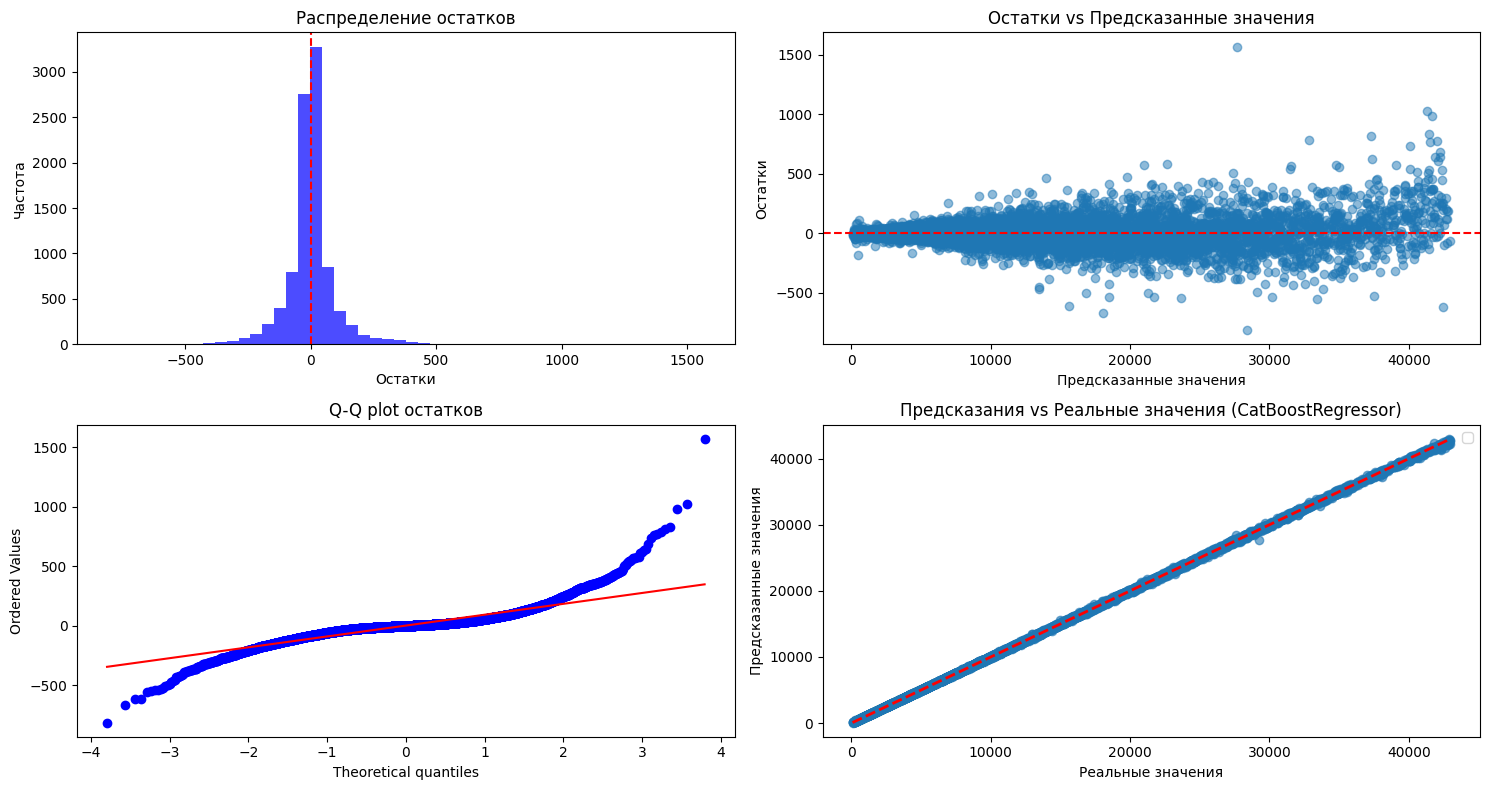

In [32]:
def evaluate_model(model, X_test, y_test, model_name):
  """Оценка модели"""
  # Предсказание
  y_pred = model.predict(X_test)

  # Обратное преобразование логарифма
  y_test_exp = np.expm1(y_test)
  y_pred_exp = np.expm1(y_pred)

  # Вычисление метрик
  mse = np.mean((y_test_exp - y_pred_exp) ** 2)
  rmse = np.sqrt(mse)
  r2 = model.score(X_test, y_test)

  print(f"\nОценка модели {model_name}:")
  print(f"MSE: {mse:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R2: {r2:.4f}")

# Детальная оценка всех моделей
print("\nДетальная оценка моделей...")
for model, name in models:
    evaluate_model(model, X_test, y_test, name)

# Загрузка и использование лучшей модели
print("\nДемонстрация работы лучшей модели...")
loaded_model = joblib.load(MODEL_SAVE_PATH)
sample = X_test.sample(1, random_state=RANDOM_STATE)
prediction = np.expm1(loaded_model.predict(sample))
actual = np.expm1(y_test.loc[sample.index])
print(f"\nПрогноз для образца: {prediction[0]:.2f}")
print(f"Фактическое значение: {actual.values[0]:.2f}")
print(f"Ошибка: {abs(prediction[0] - actual.values[0]):.2f} (%)")
print(f"Относительная ошибка: {abs(prediction[0] - actual.values[0])/actual.values[0]*100:.1f}(%)")

# График предсказаний vs реальные значения
# Предсказание
y_pred = loaded_model.predict(X_test)

# Обратное преобразование логарифма
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
# Анализ остатков для лучшей модели
residuals = y_test_exp - y_pred_exp
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
# Распределение остатков
axes[0, 0].hist(residuals, bins=50, alpha=0.7, color='blue')
axes[0, 0].axvline(x=0, color='red', linestyle='--')
axes[0, 0].set_title('Распределение остатков')
axes[0, 0].set_xlabel('Остатки')
axes[0, 0].set_ylabel('Частота')
# Остатки vs предсказанные значения
axes[0, 1].scatter(y_pred_exp, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title('Остатки vs Предсказанные значения')
axes[0, 1].set_xlabel('Предсказанные значения')
axes[0, 1].set_ylabel('Остатки')
# QQ-plot для нормальности остатков
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q plot остатков')
# Распределение целевой переменной
axes[1, 1].scatter(y_test_exp, y_pred_exp, alpha=0.6)
axes[1, 1].plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--', lw=2)
axes[1, 1].set_title(f'Предсказания vs Реальные значения (CatBoostRegressor)')
axes[1, 1].set_xlabel('Реальные значения')
axes[1, 1].set_ylabel('Предсказанные значения')
axes[1, 1].legend()
plt.tight_layout()
plt.show()


Генерируем синтетические данные для задачи регрессии

In [35]:
from sklearn.datasets import make_regression,make_classification
import pandas as pd
# X, y = make_regression(n_samples=1000, n_features=5, noise=5.0, random_state=42)

X, y = make_classification(n_samples=1000, n_features=5, n_classes=2)

import pandas as pd
df = pd.DataFrame(X, columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])
df['target'] = y
df.head()

# Разделяем данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение базовых регрессоров
regressor1 = LinearRegression()
regressor2 = DecisionTreeRegressor(random_state=42)
regressor3 = RandomForestRegressor(n_estimators=100, random_state=42)

# Определение ансамбля регрессоров (VotingRegressor)
voting_regressor = VotingRegressor(estimators=[
    ('lr', regressor1),
    ('dt', regressor2),
    ('rf', regressor3),
])

# Обучение ансамбля регрессоров
voting_regressor.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = voting_regressor.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

MAE: 0.10517789829111152
MSE: 0.03725500095343013
R²: 0.8494747436225045


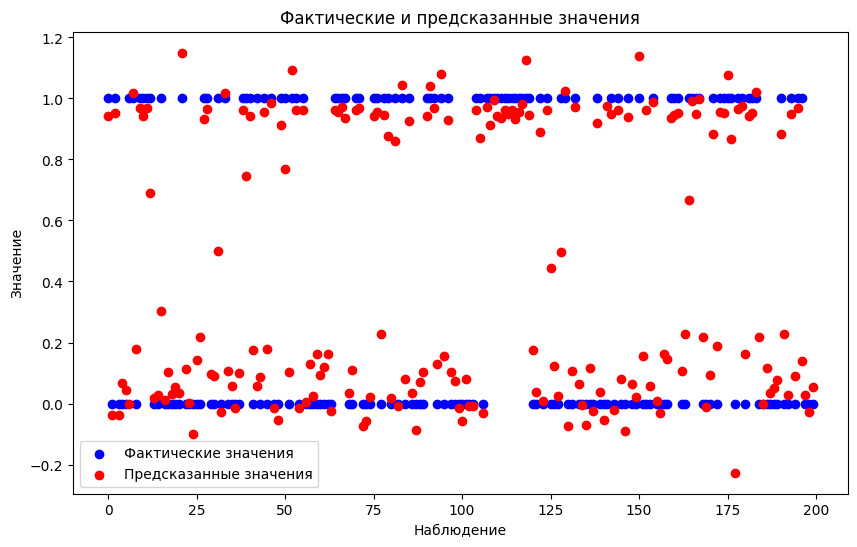

In [36]:
# Визуализация предсказанных и фактических значений
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Фактические значения')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Предсказанные значения')
plt.xlabel('Наблюдение')
plt.ylabel('Значение')
plt.title('Фактические и предсказанные значения')
plt.legend()
plt.show()